In [1]:
from classes import *
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle

In [2]:
#Load the experiments
input_path = "temp/experiments/experiment_2020_8_27.p"
output_path = os.path.dirname(input_path)
experiments = pickle.load( open( input_path, "rb" ) )
experiments

[Rotty_Bamber_2019_high_95__5_R. Active 2020/08/27, 16:17:19,
 Rotty_SROCC_2019_RCP26_17__5_R. Active 2020/08/27, 16:17:19,
 Rotty_SROCC_2019_RCP85_50__5_R. Active 2020/08/27, 16:17:20,
 Rotty_SROCC_2019_RCP85_83__5_R. Active 2020/08/27, 16:17:20]

In [3]:
for experiment in experiments:
    experiment.create_Metrics()
    for M in experiment.allMetrics:
        M.create_statistics()
        M.select_candidates()    
        #M.plot_both(figsize=(15,20),exp_name=experiment.name)

D:\Python\Urban-SETP\classes.py:841: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


### Select an interesting metric to improve the signal analysis

In [4]:
experiment = experiments[2]
experiment
#Should be: Rotty_SROCC_2019_RCP85_50__5_R. Active 2020/08/27, 16:17:20

Rotty_SROCC_2019_RCP85_50__5_R. Active 2020/08/27, 16:17:20

In [5]:
M = experiment.allMetrics[1]
M

Area_A_house_price_subj

D:\Python\Urban-SETP\classes.py:841: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


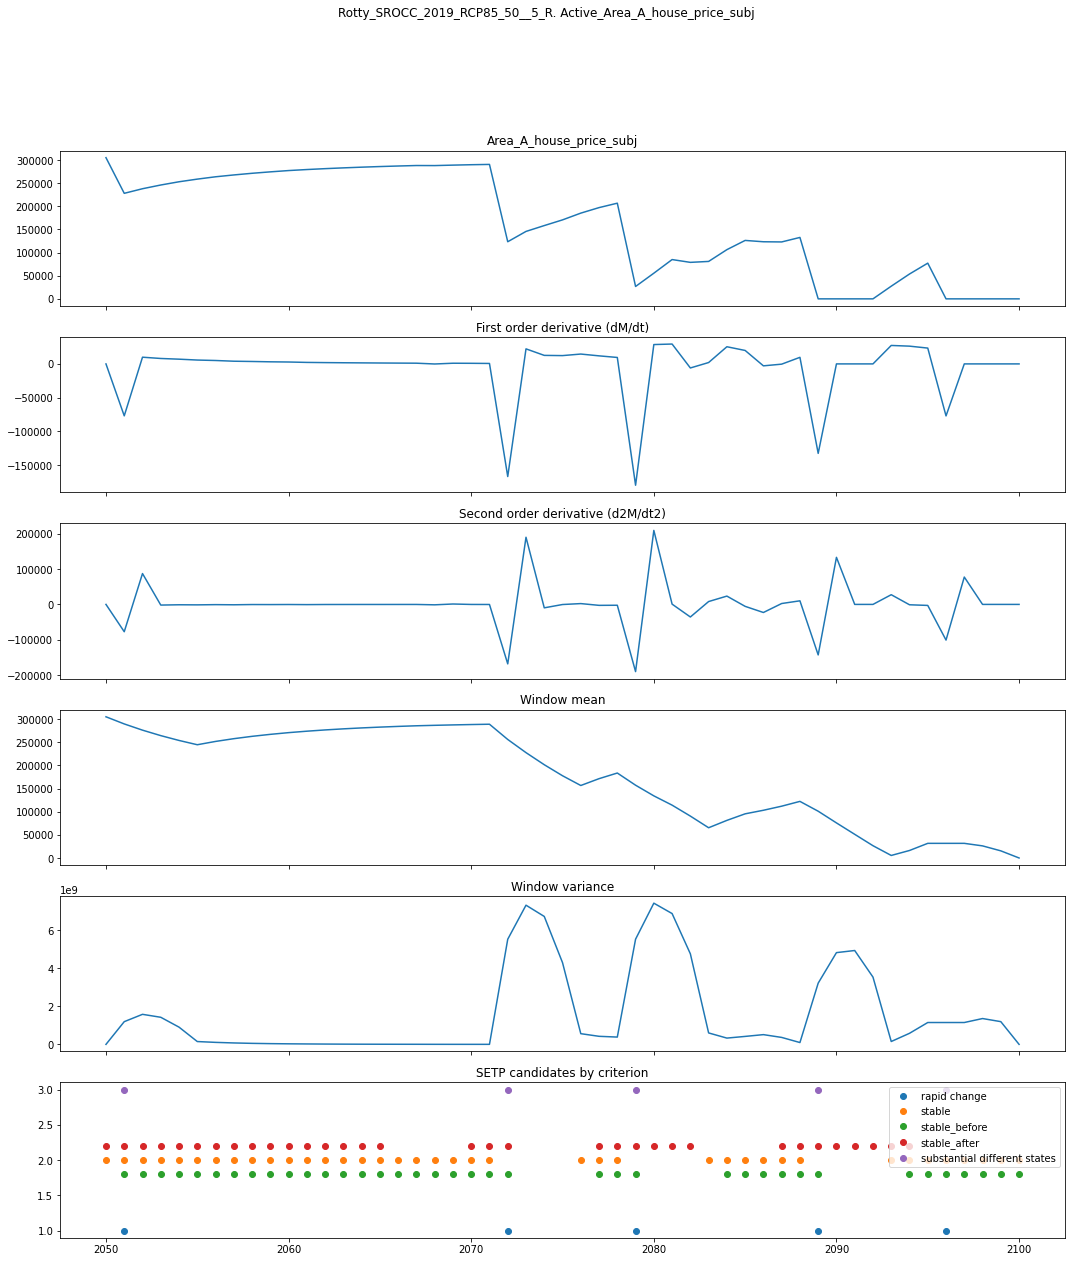

In [8]:
window = 5 #The size of the rolling window
margin = 1 # The margin around the TP
experiment.create_Metrics()
M.create_statistics(domain=(2050,2100),window=window)
M.select_candidates(window=window,margin=margin)    
M.plot_both(figsize=(18,20),exp_name=experiment.name)

In [7]:
M.candidates.loc[2070:2085]

,rapid change,stable,stable_before,stable_after,substantial different states
2070,NaN,NaN,NaN,NaN,NaN
2071,NaN,NaN,NaN,NaN,NaN
2072,1.0,2.0,NaN,NaN,3.0
2073,NaN,2.0,1.8,2.2,NaN
2074,NaN,2.0,1.8,2.2,NaN
2075,NaN,2.0,1.8,2.2,NaN
2076,NaN,NaN,1.8,2.2,NaN
2077,NaN,NaN,NaN,NaN,NaN
2078,NaN,NaN,NaN,NaN,NaN
2079,1.0,2.0,NaN,NaN,3.0


In [8]:
M.statistics.shift(periods=-5)

,Area_A_house_price_subj,First order derivative (dM/dt),Second order derivative (d2M/dt2),Window mean,Window variance
2021,305764.398578,-11.820579,-3.110679e+00,305785.986688,288.528557
2022,305752.266932,-12.131647,-3.110679e-01,305774.850459,297.188864
2023,305740.135285,-12.131647,-5.820766e-11,305763.589802,323.460077
2024,305727.692570,-12.442715,-3.110679e-01,305752.142505,367.971157
2025,305711.517042,-16.175529,-3.732814e+00,305739.202081,426.338728
...,...,...,...,...,...
2116,NaN,NaN,NaN,NaN,NaN
2117,NaN,NaN,NaN,NaN,NaN
2118,NaN,NaN,NaN,NaN,NaN
2119,NaN,NaN,NaN,NaN,NaN


In [9]:
M.candidates.head(n=2)

,rapid change,stable,stable_before,stable_after,substantial different states
2021,NaN,NaN,NaN,NaN,NaN
2022,NaN,NaN,NaN,NaN,NaN


### Experiment with K-means

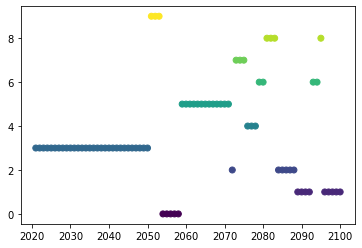

In [44]:
from sklearn.cluster import KMeans
import numpy as np
#K means Clustering 
domain = (2020,2100)

def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

series = M.raw.loc[domain[0]:domain[1]]
data = np.array(series)
data = data.reshape(-1,1)
clust_label, cent = doKmeans(data,nclust=10)
plt.scatter(series.index,clust_label,c=clust_label)